
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Logistic Regression

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- **This is an individual homework. No group collaboration.**
- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import random
import zipfile


import seaborn as sns
sns.set()


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw4.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [20 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.


**1.3** Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.

Plot two histograms ofyour best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.

Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.


**1.4** Using your top gene from the previous part (call it  `best_predictor`), create a classification model by manually eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.

<hr> <hr>

<hr>
### Solutions

**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [4]:

print(df.shape)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(df.Cancer_type.value_counts(normalize=True))

(752, 7130)
(601, 7129) (151, 7129) (601,) (151,)
0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**1.1 Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.**


In [5]:
#your code here
X_train.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
486,-83.669345,-129.202197,91.188553,-132.634919,-416.659258,-566.248620,-549.255222,-208.415176,213.331881,-135.518811,...,111.849800,371.083898,252.006568,963.153393,9.955941,142.181944,442.730023,42.848269,512.106908,4.677488
604,-65.718571,-302.842019,-297.819728,-177.485917,-52.709137,-218.295750,195.983474,-268.235930,-328.630912,240.058672,...,252.867110,110.033722,203.197907,101.612259,-138.398658,245.767616,247.519122,-15.430358,-398.165984,-61.694246
341,-264.191248,-162.255274,127.997172,173.771779,-185.191211,40.011778,-1562.983106,-85.344926,-119.622143,219.619110,...,20.797496,-184.115075,-227.872398,140.876523,42.543763,28.594281,204.479474,9.831559,21.718266,19.522122
117,-92.558574,-109.788332,379.542547,391.641129,-184.507364,-577.178389,-293.421369,-372.534572,190.551199,-487.331438,...,180.678776,577.889184,-50.443125,417.586154,-11.190519,1478.997020,15.923333,112.986515,-107.706335,-25.673203
516,-143.099813,140.202023,-147.163850,222.339115,-231.007621,-753.616356,274.500343,-217.513332,-107.135509,-62.470938,...,139.821329,909.588696,43.531613,718.462679,-58.238405,232.494165,754.787059,-58.160474,1808.764690,-20.782346


In [6]:
#your code here
X_train = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_train.head()


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
486,0.574689,0.652904,0.528552,0.202384,0.504132,0.309107,0.439480,0.524446,0.723161,0.411162,...,0.516278,0.391074,0.752595,0.484137,0.683508,0.389115,0.413169,0.562775,0.538180,0.524258
604,0.587407,0.535608,0.249427,0.171417,0.752874,0.513878,0.655342,0.464181,0.324602,0.559483,...,0.635019,0.317177,0.700050,0.336964,0.454571,0.406687,0.339430,0.452814,0.388218,0.380795
341,0.446787,0.630576,0.554963,0.413946,0.662329,0.665892,0.145850,0.648430,0.478307,0.551411,...,0.439609,0.233910,0.235984,0.343672,0.733797,0.369846,0.323172,0.500478,0.457391,0.556345
117,0.568391,0.666018,0.735454,0.564376,0.662796,0.302675,0.513584,0.359108,0.706408,0.272227,...,0.574234,0.449615,0.426995,0.390941,0.650875,0.615891,0.251946,0.695112,0.436069,0.458655
516,0.532581,0.834889,0.357527,0.447480,0.631015,0.198841,0.678084,0.515280,0.487490,0.440010,...,0.539831,0.543511,0.528163,0.442338,0.578272,0.404435,0.531047,0.372191,0.751796,0.469227


**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.**

*your answer here*
It's hard to know which predictors are correlated with which observations, because there are so many more predictors than there are observations. If we want to classify someone as having either cancer type 1 or 0, we don't have really have enough data points to be able to predict this accurately. 

**1.3** **Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.**

**Plot two histograms of your best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.**

**Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.**

In [7]:
# first add back the column Cancer_type into a new df
X_train_withcol = X_train.join(y_train)
X_train_withcol.tail()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,Cancer_type
171,0.592375,0.712934,0.431887,0.382571,0.807916,0.425600,0.487775,0.580564,0.751129,0.353074,...,0.351106,0.406197,0.465391,0.380890,0.488301,0.279890,0.260689,0.478843,0.299991,1.0
39,0.391658,0.605079,0.492540,0.520434,0.635805,0.391055,0.408561,0.440241,0.667027,0.407813,...,0.575616,0.553427,0.356163,0.459816,0.547188,0.425359,0.572495,0.481490,0.362842,0.0
216,0.519226,0.536045,0.310269,0.346750,0.642911,0.368551,0.469412,0.541526,0.741393,0.424832,...,0.451368,0.462922,0.366545,0.747585,0.405468,0.391495,0.629281,0.396947,0.222790,0.0
250,0.556494,0.658618,0.525451,0.342720,0.737993,0.417116,0.759100,0.567515,0.484216,0.340849,...,0.617136,0.472328,0.360290,0.514443,0.349168,0.341537,0.506765,0.410023,0.734160,0.0
314,0.627462,0.812887,0.531998,0.418090,0.630784,0.333590,0.521112,0.712001,0.496368,0.367290,...,0.422390,0.410395,0.304385,0.626967,0.357442,0.422998,0.600107,0.480528,0.169291,0.0


In [8]:
#create 2 dataframes for the ttest
df1 = X_train_withcol[X_train_withcol['Cancer_type']== 0]
df2 = X_train_withcol[X_train_withcol['Cancer_type']== 1]

#generate empty list in which to place top 10 ttest tuples
gene_list = []

#iterate through all of the columns and get a ttest for each one
for col in X_train.columns:
    t_test = ttest_ind(df1[col], df2[col])[0]
    if len(gene_list) < 10:
        gene_list.append((t_test, col))
        gene_list.sort(key=lambda x: x[0], reverse=True)
    elif abs(t_test) > gene_list[-1][0]:
        del gene_list[-1]
        gene_list.append((abs(t_test), col))
        gene_list.sort(key=lambda x: x[0], reverse=True)

gene_list

[(12.508945125280942, 'M31523_at'),
 (12.420906430991636, 'X95735_at'),
 (11.959086444234588, 'M84526_at'),
 (11.492568613357982, 'X61587_at'),
 (11.037283595774586, 'U50136_rna1_at'),
 (10.67950628540202, 'X17042_at'),
 (10.467596860564399, 'U29175_at'),
 (10.27233985386208, 'Y08612_at'),
 (10.102831690606612, 'Z11793_at'),
 (10.037462874454242, 'X76648_at')]

In [9]:
#your code here
# normalize x_test and add back the columns
X_test = pd.DataFrame(MinMaxScaler().fit_transform(X_test), columns=X_test.columns, index=X_test.index)
X_test_withcol = X_test.join(y_test)
X_test_withcol.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,Cancer_type
515,0.603413,0.543559,0.705673,0.064785,0.704512,0.552645,0.873314,0.897127,0.364208,0.060419,...,0.565091,0.522899,0.249725,0.461977,0.596099,0.573292,0.653384,0.346764,0.566955,0.0
192,0.054278,0.761988,0.333989,0.558916,0.639296,0.502498,0.578955,0.493494,0.549394,0.301547,...,0.655568,0.672485,0.138999,0.793316,0.690313,0.774283,0.810288,0.307707,0.322158,0.0
457,0.002760,0.641026,0.619720,0.321659,0.369666,0.589841,0.595852,0.692368,0.688388,0.402360,...,0.804191,0.814558,0.068333,0.892572,0.795807,0.629698,0.747733,0.490526,0.485862,1.0
577,0.502416,0.739548,0.290271,0.473453,0.658558,0.448358,0.477622,0.791720,0.685651,0.188699,...,0.366905,0.323419,0.333634,0.598958,0.299373,0.129640,0.346889,0.256287,0.365986,0.0
141,0.388281,0.820114,0.446626,0.546502,0.520474,0.669415,0.265966,0.525799,0.305133,0.352919,...,0.350642,0.764849,0.220399,0.548560,0.641241,0.222862,0.352228,0.282541,0.473558,1.0


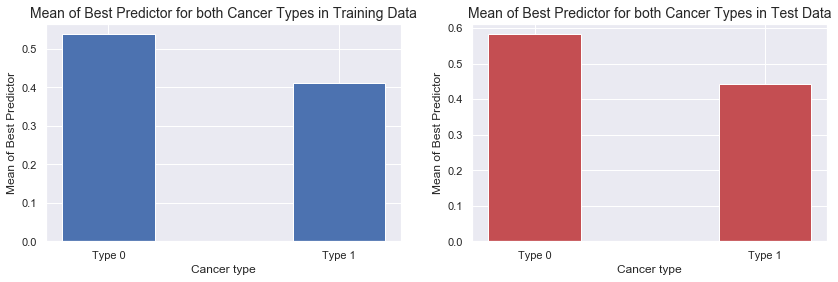

In [10]:
# assign best predictor
best_predictor = gene_list[0][1]

#get the means of best predictor for each cancer type on both training and test set
type_0_mean = X_train_withcol[best_predictor][X_train_withcol['Cancer_type']== 0].mean()
type_1_mean = X_train_withcol[best_predictor][X_train_withcol['Cancer_type']== 1].mean()
test_type_0_mean = X_test_withcol[best_predictor][X_test_withcol['Cancer_type']== 0].mean()
test_type_1_mean = X_test_withcol[best_predictor][X_test_withcol['Cancer_type']== 1].mean()

training_means = [type_0_mean, type_1_mean]
test_means = [test_type_0_mean, test_type_1_mean]

# x axis of histogram
cancer_type = ['Type 0', 'Type 1']

# plot histograms
plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.bar(cancer_type, training_means, color='b', width = .4)
plt.title('Mean of Best Predictor for both Cancer Types in Training Data', fontsize = 14)
plt.xlabel('Cancer type')
plt.ylabel('Mean of Best Predictor')

plt.subplot(1,2,2)
plt.bar(cancer_type, test_means, color='r', width = .4)
plt.title('Mean of Best Predictor for both Cancer Types in Test Data', fontsize = 14)
plt.xlabel('Cancer type')
plt.ylabel('Mean of Best Predictor');


**1.4 Using your top gene from the previous part (call it  `best_predictor`), create a classification model by eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.**


In [11]:
# make the cutoff equal the midway point between the means for the 2 cancer types.
# I chose this cutoff because it makes sense that if we are trying to discriminate between the 
#2 cancer types based on the value of this predictor, we should take the middle point of the 
#mean values of this predictor for each of the 2 cancer types. 
cutoff = np.average(training_means)

# report accuracy on the test set
sum_right = 0
for index, row in X_test_withcol.iterrows():
    predicted_type = 1
    if row[best_predictor] > cutoff:
        predicted_type = 0
    if predicted_type == row['Cancer_type']:
        sum_right += 1

percentage_right = sum_right / X_test_withcol.shape[0]
print("This model predicted Cancer type correctly {:.3f} % of the time".format(100*percentage_right))

This model predicted Cancer type correctly 68.874 % of the time


<div class='exercise'><b> Question 2 [25 pts]: Linear and Logistic Regression  </b></div>


In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor that you identify as the best predictor above to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML). Is there a problem with this interpretation?


Create a figure with following items displayed on the same plot (use training data):
 - the predicted quantitative response from the linear regression model as a function of the best gene predictor
 - the true binary response. 


**2.2** Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.


**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000'). 


**2.4** 
Print and interpret the logistic regression coefficients: the 'slope' and intercept. 


Create 2 plots (one each for training and testing data) with 4 items displayed on each plot.
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 



<hr>
### Solutions

**2.1** **Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML).  Is there a problem with this interpretation?**



In [12]:
# make the model
data_x_train = X_train[best_predictor]
data_y_train = X_train_withcol['Cancer_type']

regr = LinearRegression(fit_intercept=True)

regr.fit(data_x_train.values.reshape(-1,1), data_y_train);

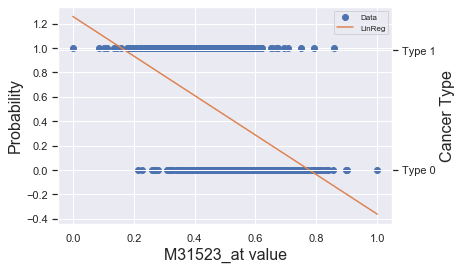

In [13]:
# make the plot. Based off the lecture notes. 
fig = plt.figure()

host = fig.add_subplot(111)
par1 = host.twinx()

#set labels
host.set_xlabel("{} value".format(best_predictor), fontsize = 16)
host.set_ylabel("Probability", fontsize = 16)
par1.set_ylabel("Cancer Type", fontsize = 16)
labels = ['Type 0', 'Type 1']
par1.set_yticks( [0.25, 0.8])
par1.set_yticklabels(labels)


#get predictions
x_train = np.linspace(np.min(data_x_train),np.max(data_x_train), len(data_x_train))
y_train_lin = regr.predict(x_train.reshape(-1,1))

#make plots
host.plot(data_x_train, data_y_train, 'o' , label='Data')
host.plot(x_train, y_train_lin, label='LinReg')
host.legend(loc='best', fontsize = 8)

plt.show()

*your answer here* 
There is a problem with this interpretation. The model could predict values that are nonsensical. This would be the case if it predicted any value outside the range of (0,1), since it could not be interpreted as a probability. 

**2.2** **Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.**

In [14]:
# create a function to evaluate percentage correct given inputs 
def percentage(y_predictions, y_data, cutoff):
    predictions = []
    for value in y_predictions:
        if value > cutoff:
            prediction = 1
        else:
            prediction = 0
        predictions.append(prediction)

    sum_right = 0
    for index, value in enumerate(y_data):
        if predictions[index] == value:
            sum_right +=1
    return sum_right / len(predictions)

In [15]:
# apply function to train data
percentage_train = percentage(y_train_lin, data_y_train, .5)
print('Percentage correct on training set using standard Bayes classifier is {:.3f}%'.format(100*percentage_train))

#get predictions for test data
data_x_test = X_test[best_predictor]
data_y_test = X_test_withcol['Cancer_type']
x_test = np.linspace(np.min(data_x_test),np.max(data_x_test), len(data_x_test))
y_test_lin = regr.predict(x_test.reshape(-1,1))

#apply function to test data
percentage_test = percentage(y_test_lin, data_y_test, .5)
print('Percentage correct on test set using standard Bayes classifier is {:.3f}%'.format(100*percentage_test))

Percentage correct on training set using standard Bayes classifier is 53.078%
Percentage correct on test set using standard Bayes classifier is 49.007%


In [16]:
# simple logistic model

logreg = LogisticRegression(C=100000, fit_intercept=True,solver='lbfgs')
logreg.fit(data_x_train.values.reshape(-1,1), data_y_train);

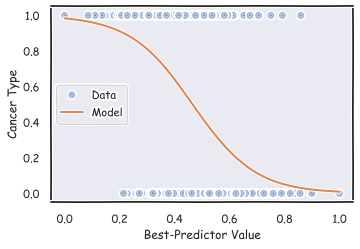

In [17]:
# plot the model overlayed on the data
fig = plt.figure()
fig.patch.set_alpha(0.0)
plt.xkcd(scale=0.1, length=0.0)
plt.gcf().subplots_adjust(bottom=0.20, left = 0.16, right=0.86)


y_train_log = logreg.predict_proba(x_train.reshape(-1,1))[:,1]
plt.plot(data_x_train, data_y_train, 'o' ,alpha=0.4, label='Data')
plt.plot(x_train,y_train_log, label='Model')
plt.legend()

plt.xlabel("Best-Predictor Value")
plt.ylabel("Cancer Type");

*your answer here* 


**2.4 Print and interpret the logistic regression coefficients: the 'slope' and the intercept.**

**Create 2 plots (with training and test data) with 4 items displayed on each plot.**
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$.

**Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer.** 


In [18]:
# your code here
print('Estimated beta1: \n', logreg.coef_)
print('Estimated beta0: \n', logreg.intercept_)

Estimated beta1: 
 [[-8.75716206]]
Estimated beta0: 
 [4.07730445]


beta1 controls how steep the s curve of the logistic function is. A 1 unit change in x is associated with a beta1 change in the log-odds of Y=1. In this case, since beta1 is negative, this indicates that as X increases (i.e. the value of best-predictor increases) the probability that Y=1 decreases. Beta0 shifts the logistic curve either to the right or the left (by C = -beta0/beta1). In this case, the shift is approximately .5 to the right. 

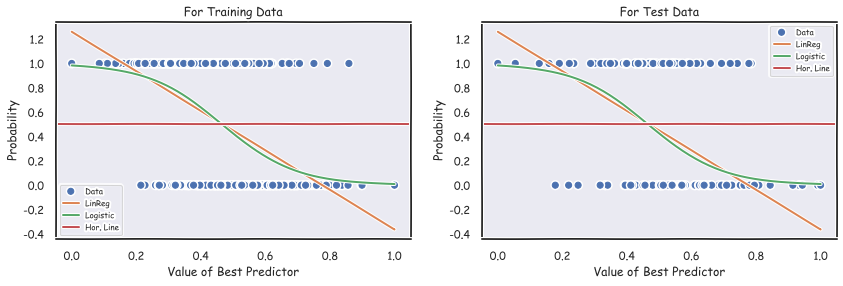

In [19]:
# your code here
plt.figure(figsize=[14,4])

#for training data
plt.subplot(1,2,1)

#plot true binary response
plt.plot(data_x_train, data_y_train, 'o' , label='Data')
#plot linear regression predicted quantitative response
plt.plot(x_train, y_train_lin, label='LinReg')
#plot logistic regression predicted probability
plt.plot(x_train, y_train_log, label='Logistic')
#plot horizontal line at .5
plt.axhline(y=0.5, color='r', linestyle='-', label='Hor. Line')

#labels
plt.title('For Training Data')
plt.xlabel('Value of Best Predictor')
plt.ylabel('Probability')
plt.legend(loc ='best', fontsize = 8)


# plot for test data
plt.subplot(1,2,2)
plt.title('For Test Data')
plt.xlabel('Value of Best Predictor')
plt.ylabel('Probability')

#generate logistic predictions for test data
y_test_log = logreg.predict_proba(x_test.reshape(-1,1))[:,1]

#plot true binary response
plt.plot(data_x_test, data_y_test, 'o' , label='Data')
#plot linear regression predicted quantitative response
plt.plot(x_test, y_test_lin, label='LinReg')
#plot logistic regression predicted probability
plt.plot(x_test, y_test_log, label='Logistic')
#plot horizontal line at .5
plt.axhline(y=0.5, color='r', linestyle='-', label='Hor. Line')

#labels
plt.title('For Test Data')
plt.xlabel('Value of Best Predictor')
plt.ylabel('Probability')
plt.legend(loc ='best', fontsize = 8);

It doesn't appear that the logistic model is really that much better than the linear model. They both intersect the horizontal line y=.5 at the same place, which means that they would both make the same predictions. Obviously the logistic model fits the data better since it is by definition bounded between 0 and 1. However, the fact the linear model isn't bounded is irrlevant for predictions, since all we care about is whether the prediction is above or below the line y=.5. 

<div class='exercise'> <b> Question 3 [20pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.  


**3.3** Comment on the classification accuracy of training and test set? Given the results above how would you assess the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole? 

**3.4** Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.

**3.5** Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).

<hr>
### Solutions

**3.1** **Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?**  


In [20]:
# make mlr model
data_x_train_mlr = X_train
data_x_test_mlr = X_test

mlr_reg = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs')
mlr_reg.fit(data_x_train_mlr, data_y_train)

#get per. of correct predictions for MLR model (training data)
y_train_mlr = mlr_reg.predict_proba(data_x_train_mlr)[:,1]
percentage_mlr_train = percentage(y_train_mlr, data_y_train, .5)
# test data
y_test_mlr = mlr_reg.predict_proba(data_x_test_mlr)[:,1]
percentage_mlr_test = percentage(y_test_mlr, data_y_test, .5)

print('MLR model: {:.3f}% on training data, and {:.3f}% on test data'.format(100*percentage_mlr_train, 100*percentage_mlr_test))

MLR model: 100.000% on training data, and 72.848% on test data


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [21]:
#get per. of correct predictions for Best-Predictor log model (training data)
percentage_log_train = percentage(y_train_log, data_y_train, .5)
# test data
y_test_log = logreg.predict_proba(x_test.reshape(-1,1))[:,1]
percentage_log_test = percentage(y_test_log, data_y_test, .5)

print('Simple log model (from question 2): {:.3f}% on training data, and {:.3f}% on test data'.format(100*percentage_log_train, 100*percentage_log_test))

Simple log model (from question 2): 52.912% on training data, and 48.344% on test data


*your answer here* 
This new model is much much better than the models developed solely based on the Best Predictor. On the training data the new model had 100% accuracy, which seems to indicate that it is overfit. However, it still had over 70% accuracy on the test data, which is much better than the 50% scored by the first model (which is essentially the same as just flipping a coin to determine which group to predict!)

**3.2** **How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.**

**Hint:** **To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.**  


In [22]:
# Pseudocode

# bootstrap the data 100 times and fit a model to each dataset 
# this will give you a distribution for the betas (100 different points)
# calculate the 95% confidence interval for that list of 100 betas. If it contains zero then it 
# isn't significant, otherwise it is. Just to output the number that are significant. 
#pandas sample command (with replacement), or numpy random choice (with replacement). 
# every new dataset should have the same number of rows as the initial one. 
# only doing this on the training data.

In [23]:
#create dictionary to hold lists of betas
d = {}
d['beta0'] = []
for i in range(len(X_train.columns)):
    d["beta" + str(i+1)] = []

#turn X_train into numpy array
b = X_train.to_numpy()
    
#bootstrap 100 times and save beta values in dictionary
for i in range(100):
    #generate list a by sampling from numpy array b
    a = np.zeros((len(b),len(b[0])))
    for i in range(len(b[0])):
        a[:,i] = np.random.choice(b[:,i], size = 601, replace=True)
    #turn a back into dataframe and fit a model
    df = pd.DataFrame(a)
    mlr_reg = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs')
    mlr_reg.fit(df, data_y_train)
    #store lists of betas in dictionary d
    d['beta0'].append(mlr_reg.intercept_[0])
    for index, value in enumerate(mlr_reg.coef_[0]):
        d['beta' + str(index + 1)].append(value)

In [24]:
# get 95% confidence intervals for each predictor, and count how many don't include 0
import statsmodels.stats.api as sms
sig_predict = 0
for item in d.items():
    conf_int = sms.DescrStatsW(item[1]).tconfint_mean(alpha = .05)
    if (conf_int[0] > 0 and conf_int[1] > 0) or (conf_int[0] < 0 and conf_int[1] < 0):
        sig_predict += 1
sig_predict

369

**3.3 Open question: Comment on the classification accuracy of training and test set? Given the results above how would you assest the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole.**

*your answer here*

????

**3.4 Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.**

In [25]:
# Create model using cross validation on the regularized logistic regression model
# Use k value of 10 for cross validation, and use 'l1' to get LASSO-like regularization
logit = LogisticRegressionCV(cv=10, solver='liblinear', penalty='l1', fit_intercept=True)
logit.fit(data_x_train_mlr, data_y_train)

#get percentage of correct predictions for regularized and validated MLR model (on training data)
y_train_mlr_reg = logit.predict_proba(data_x_train_mlr)[:,1]
percentage_mlr_train_reg = percentage(y_train_mlr_reg, data_y_train, .5)
# do the same for test data
y_test_mlr_reg = logit.predict_proba(data_x_test_mlr)[:,1]
percentage_mlr_test_reg = percentage(y_test_mlr_reg, data_y_test, .5)

print('Regularized MLR model: {:.3f}% on training data, and {:.3f}% on test data'.format(100*percentage_mlr_train_reg, 100*percentage_mlr_test_reg))

Regularized MLR model: 91.015% on training data, and 82.119% on test data


**3.5: Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).**

In [26]:
# print gene list for recollection purposes
gene_list

[(12.508945125280942, 'M31523_at'),
 (12.420906430991636, 'X95735_at'),
 (11.959086444234588, 'M84526_at'),
 (11.492568613357982, 'X61587_at'),
 (11.037283595774586, 'U50136_rna1_at'),
 (10.67950628540202, 'X17042_at'),
 (10.467596860564399, 'U29175_at'),
 (10.27233985386208, 'Y08612_at'),
 (10.102831690606612, 'Z11793_at'),
 (10.037462874454242, 'X76648_at')]

In [27]:
# get the index of all of the nonzero coefficients of the new model
betas = []
for index, value in enumerate(logit.coef_[0]):
    if value > 0:
        betas.append(index)
betas

[21,
 391,
 674,
 1111,
 1597,
 1709,
 1744,
 1778,
 1881,
 2181,
 2241,
 2287,
 2738,
 2840,
 2885,
 2990,
 3216,
 3251,
 3319,
 3713,
 4246,
 4348,
 4365,
 4513,
 4774,
 4846,
 4950,
 5053,
 5076,
 5413,
 5459,
 6377,
 6538,
 6615]

In [28]:
# count how many of the nonzero coefficients are in gene_list
sum = 0
for item in gene_list:
    if X_train.columns.get_loc(item[1]) in betas:
        sum +=1
sum

5

*your answer here* 
The ten best predictors from question 1 do not hold up as important in this regularized model. In fact they are all equal to zero!


why?????

<div class='exercise'> <b> Question 4 [25pts]: Multi Class Log Regression </b> </div>

**4.1** Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset? 

**4.2** Split the dataset into train and test, 80-20 split, random_state = 8. 

We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using the training dataset.  It should be easily discernable via labeling/marking in the plot which observations belong to which `cancer_type`.

**4.3** Fit the following two models using crossvalidation: 
- Logistic Regression Multiclass model with linear features. 
- Logistic Regression Multiclass model with Polynomial features, degree = 2.

**4.4** Plot the decision boundaries for each model and interpret the results. Hint: You may utilize the function `overlay_decision_boundary`. 

**4.5** Report and plot the CV scores for the two models and interpret. 


<hr>
### Solutions

**4.1 Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset?**

In [29]:
#read data into pandas object and examine it
df = pd.read_csv('data/hw4_mc_enhance.csv', index_col=0)
df.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
0,-1363.276427,-1058.585495,-541.469194,74.349803,-1110.082554,-1545.661845,-2037.029616,-1255.990888,-335.480958,-938.425691,...,1565.618803,-485.680714,-170.261227,-919.114293,1675.050053,389.769289,-526.449219,-268.963924,-779.643092,0.0
1,-796.285053,-1167.103365,7.538493,83.544731,-1116.432539,-1731.392100,249.376523,-1636.960108,-149.080421,-222.783440,...,622.498054,-1275.354673,214.828233,-750.220666,-441.589276,9.841713,-671.911209,-671.911209,-644.272577,0.0
2,-679.139168,-1069.832308,-690.301829,-112.075981,-1199.319178,-1286.387935,-605.465604,-1043.041921,-728.254877,388.011238,...,162.525483,-692.534361,517.498108,-674.674103,1265.396405,-65.192805,-714.859684,3672.066149,-822.021231,0.0
3,-1164.400197,-1109.939891,-990.127218,-238.574994,-1264.607160,-1218.860503,-1255.893511,-1009.732928,-521.768585,-926.953263,...,-31.625831,-621.975549,-458.594630,-630.689198,937.767618,-264.715941,-635.046022,475.944222,-794.070116,0.0
4,-1299.653758,-1401.998536,-1077.543813,-437.344560,-1386.755697,-1726.453259,-1499.988218,-1219.084464,-994.796971,-670.342247,...,383.591216,-905.517483,-36.675640,-1116.739685,316.087213,-210.879518,-953.423549,-291.448812,-1057.945876,0.0


In [30]:
#normalize data
cancer_type = df['cancer_type']
predictors = df.drop('cancer_type', axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(predictors), columns=predictors.columns, index=predictors.index)
df['cancer_type'] = cancer_type
df.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
0,0.398247,0.551210,0.615958,0.845860,0.520589,0.582350,0.197411,0.372916,0.633686,0.241601,...,0.679188,0.796316,0.115147,0.477487,0.468781,0.557773,0.865511,0.140265,0.503827,0.0
1,0.747286,0.467418,0.929572,0.853597,0.516808,0.470725,0.815944,0.070383,0.762123,0.523331,...,0.349151,0.166721,0.180014,0.657210,0.027187,0.385278,0.667490,0.083605,0.635241,0.0
2,0.819401,0.542526,0.530939,0.688981,0.467463,0.738176,0.584687,0.542022,0.363049,0.763785,...,0.188187,0.631395,0.230998,0.737601,0.383315,0.351211,0.609023,0.694427,0.462687,0.0
3,0.520675,0.511557,0.359668,0.582531,0.428595,0.778760,0.408729,0.568473,0.505326,0.246118,...,0.120246,0.687650,0.066578,0.784406,0.314962,0.260623,0.717675,0.245009,0.489821,0.0
4,0.437413,0.286044,0.309732,0.415265,0.355876,0.473693,0.342695,0.402224,0.179391,0.347139,...,0.265547,0.461586,0.137649,0.267189,0.185261,0.285066,0.284258,0.137104,0.233658,0.0


In [31]:
#get counts of each type of sickness
df['cancer_type'].value_counts()

2.0    250
1.0    250
0.0    250
Name: cancer_type, dtype: int64

In [32]:
print("There are 250 instances each of type 0, 1, and 2")

There are 250 instances each of type 0, 1, and 2


**4.2 Split the dataset into train and test, 80-20 split, random_state = 8.**

**We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using training dataset.  We should be able to discern from the plot which sample belongs to which `cancer_type`.** 

In [33]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'cancer_type'], 
                                                         df.cancer_type, test_size=0.2, 
                                                         random_state = 8, 
                                                         stratify = df.cancer_type)

In [34]:
# make sure the split is good 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head()
#y_train.head()

(600, 7129) (150, 7129) (600,) (150,)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
243,0.698362,0.763718,0.879199,0.444021,0.512402,0.517067,0.636075,0.607456,0.598981,0.543375,...,0.470174,0.864057,0.598993,0.099637,0.709386,0.271751,0.489058,0.845650,0.109994,0.590157
414,0.500044,0.387926,0.305501,0.621930,0.114741,0.260100,0.465069,0.157150,0.574517,0.530250,...,0.350330,0.301330,0.356318,0.125884,0.425863,0.966680,0.213365,0.266787,0.273698,0.337287
527,0.601034,0.609234,0.048086,0.588175,0.175496,0.154716,0.565369,0.061838,0.554631,0.100761,...,0.594818,0.731705,0.571134,0.040382,0.656276,0.424983,0.730573,0.501366,0.126306,0.318584
187,0.693236,0.649599,0.338885,0.612649,0.450144,0.883405,0.493701,0.586650,0.389110,0.514012,...,0.477123,0.306917,0.680685,0.118524,0.663627,0.163521,0.148915,0.554049,0.124675,0.556171
117,0.546943,0.473984,0.364881,0.323127,0.335872,0.653037,0.457369,0.536356,0.260484,0.443540,...,0.368432,0.277371,0.476003,0.196170,0.382175,0.252388,0.263598,0.413310,0.052135,0.348250


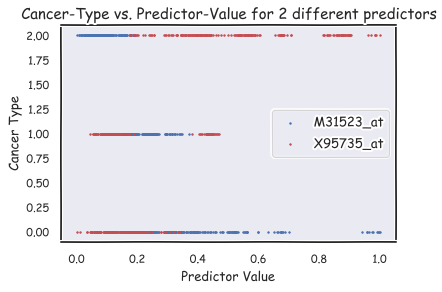

In [35]:
plt.scatter(X_train['M31523_at'], y_train, color='b', s=2, label='M31523_at')
plt.scatter(X_train['X95735_at'], y_train, color='r', s=2, label='X95735_at')
plt.legend(loc='best', fontsize=13)
plt.xlabel('Predictor Value', fontsize=13)
plt.ylabel('Cancer Type', fontsize=13)
plt.title('Cancer-Type vs. Predictor-Value for 2 different predictors', fontsize=15);

**4.3  Fit the following two models using crossvalidation:**

**Logistic Regression Multiclass model with linear features.**

**Logistic Regression Multiclass model with Polynomial features, degree = 2.**


In [36]:
# linear model
logitm1 = LogisticRegressionCV(cv=5, solver='liblinear', penalty='l1', multi_class='ovr')
logitm1.fit(X_train[['M31523_at','X95735_at']], y_train)
# The coefficients
print('Estimated beta1: \n', logitm1.coef_)
print('Estimated beta0: \n', logitm1.intercept_)

Estimated beta1: 
 [[ 13.32538496  -4.53173029]
 [ -6.03040979  -6.85439721]
 [-52.90710001  23.5706163 ]]
Estimated beta0: 
 [-2.94787408  2.30278248  1.99723393]


In [37]:
#add polynomial terms of degree 2
X_train_poly = X_train[['M31523_at','X95735_at']].copy()
X_train_poly['M31523_at_squared'] = X_train_poly['M31523_at']**2
X_train_poly['X95735_at_squared'] = X_train_poly['X95735_at']**2
# model with polynomial terms
logitm2 = LogisticRegressionCV(cv=5, solver='liblinear', penalty='l1', multi_class='ovr')
logitm2.fit(X_train_poly, y_train)
# The coefficients
print('Estimated beta1: \n', logitm2.coef_)
print('Estimated beta0: \n', logitm2.intercept_)

Estimated beta1: 
 [[ -71.33509674   64.05472506  241.22163883 -175.55226721]
 [  17.30008775   -5.13575407  -47.1970957     0.        ]
 [ 112.50901358   64.68910681 -510.41886399  -49.94740492]]
Estimated beta0: 
 [ -2.24440702  -0.35915062 -16.19351529]


**4.4 Plot the decision boundary and interpret results. Hint: You may utilize the function `overlay_decision_boundary`** 


In [38]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(X)
    #print("Do I predict" , y)
    
    
#     y[np.where(y=='aml')]=3
#     y[np.where(y=='allT')]=2
#     y[np.where(y=='allB')]=1
    
    
    
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

In [39]:
def overlay_decision_boundary_poly(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), xx.flatten(), yy.flatten(), yy.flatten()]

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(X)
    #print("Do I predict" , y)
    
    
#     y[np.where(y=='aml')]=3
#     y[np.where(y=='allT')]=2
#     y[np.where(y=='allB')]=1
    
    
    
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

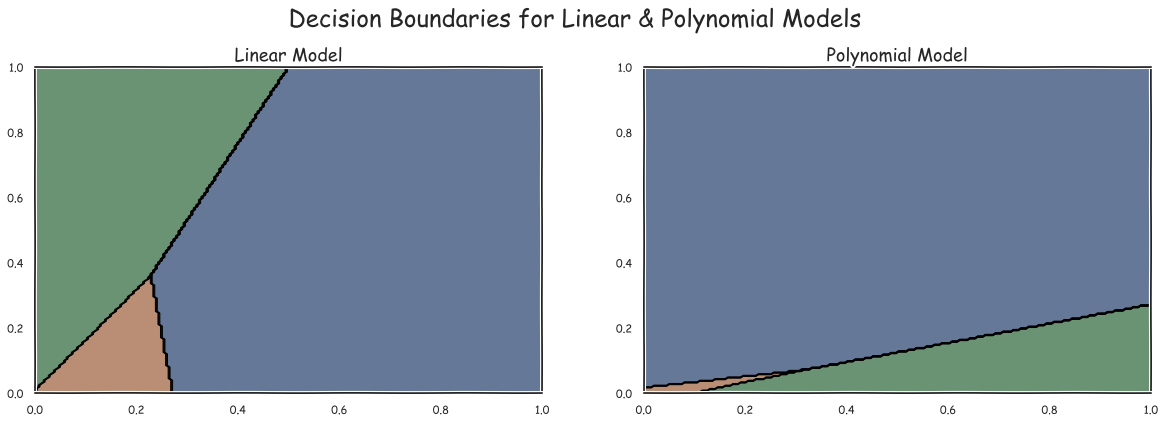

In [40]:
# Your code here
#make figure
fig, ax = plt.subplots(1,2, figsize=(20,6))
fig.suptitle('Decision Boundaries for Linear & Polynomial Models', size = 24, y = 1.02)

# boundary for linear model
overlay_decision_boundary(ax[0], logitm1)
ax[0].set_title('Linear Model', fontsize=18)
#boundary for polynomial model
overlay_decision_boundary_poly(ax[1], logitm2)
ax[1].set_title('Polynomial Model',fontsize=18);

How do I interpret these???

**4.5 Report and plot the CV scores for the two models and interpret.**

In [41]:
# get CV scores for linear model
scores1 = logitm1.scores_
#scores1 is a dictionary. Each cancer type is a key. The value is a 2d numpy array where each
#row is one test-validation split, with different values of the penalty used in regularization
for item in scores1.items():
    for i in range(5):
        print(item[0], np.average(item[1][i]))
    print()

0.0 0.8191666666666666
0.0 0.8099999999999999
0.0 0.8024999999999999
0.0 0.8083333333333333
0.0 0.8150000000000001

1.0 0.7741666666666666
1.0 0.7608333333333333
1.0 0.7816666666666666
1.0 0.7775000000000001
1.0 0.7766666666666666

2.0 0.8491666666666667
2.0 0.875
2.0 0.8733333333333334
2.0 0.8783333333333333
2.0 0.8758333333333335



There are 15 CV scores reported above, 5 for each of the 3 models (since I used 'ovr' so it makes 3 separate models, one for each of the possible outcomes). Since I did regularization as well, I simply averaged the CV scores for each row (since the row is one instance of train-validation split). We can clearly see that the CV scores for each model do not vary very much, which indicates that the model will perform similarly when faced with the test data. The model was best at predicting type 2.0, second best at type 1.0, and worst at type 0.0, although still pretty good there as well.  

In [42]:
# get CV scores for polynomial model
scores2 = logitm2.scores_

for item in scores2.items():
    for i in range(5):
        print(item[0], np.average(item[1][i]))
    print()

0.0 0.8233333333333335
0.0 0.8116666666666668
0.0 0.7958333333333333
0.0 0.8241666666666667
0.0 0.8291666666666666

1.0 0.7433333333333334
1.0 0.7158333333333333
1.0 0.7874999999999999
1.0 0.7725
1.0 0.74

2.0 0.8566666666666667
2.0 0.875
2.0 0.8733333333333334
2.0 0.8758333333333332
2.0 0.8733333333333333



Same exact structure as above. Here the CV scores differ more than they do in the linear model. For type 0.0, the CV scores range from .79 to .83, and for type 1.0 they range from .72 to .79, which is a much wider range than the linear model. This indicates that we can be less sure about the score of this model on the test data.  

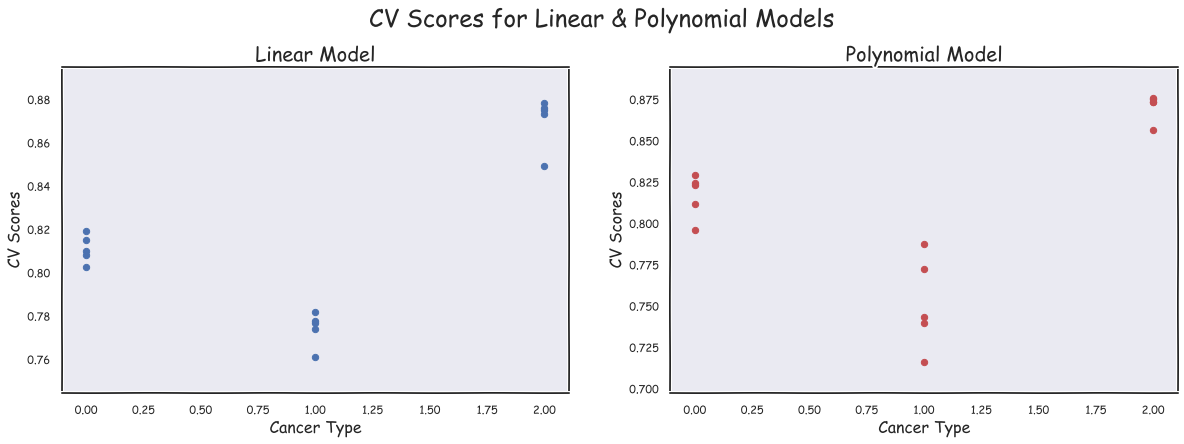

In [43]:
# store CV scores for both models
x1,x2,y1,y2 = [],[],[],[]
for item in scores1.items():
    for i in range(5):
        x1.append(item[0])
        y1.append(np.average(item[1][i]))
for item in scores2.items():
    for i in range(5):
        x2.append(item[0])
        y2.append(np.average(item[1][i]))
        
#make figure
fig, ax = plt.subplots(1,2, figsize=(20,6))
fig.suptitle('CV Scores for Linear & Polynomial Models', size = 24, y = 1.02)

ax[0].set_title('Linear Model', fontsize=20)
ax[0].scatter(x1,y1, s=40, color='b')

ax[1].set_title('Polynomial Model',fontsize=20);
ax[1].scatter(x2,y2, s=40,color='r')

for i in range(2):
    ax[i].set_xlabel('Cancer Type', fontsize=16)
    ax[i].set_ylabel('CV Scores', fontsize=16)

<div class='exercise'><b> Question 5: [10 pts] Including an 'abstain' option </b></div>

One of the reasons a hospital might be hesitant to use your cancer classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a specialist, which would incur additional cost.  How could one design a cancer classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**5.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from **Question 4**.  Note that this needs to be evaluated on the patients in the test set. 

**5.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.

<hr>
### Solutions

**5.1 More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 4.  Note that this needs to be evaluated on the patients in the test set.**
**
...
**

*your answer here* 


In [44]:
# your code here


**5.2 Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.**

In [45]:
# your code here
